Emani Jones
SUID:637061597
NLP Assignment 3

#Load Data

##Load Packages

In [ ]:
import re, nltk, torch, nltk
import numpy as np
from numpy import asarray, zeros
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
#rom keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
!pip install transformers
!pip install allennlp.modules.elmo
from transformers import XLNetModel, XLNetTokenizer, BertTokenizer, BertModel
#from allennlp.modules.elmo import Elmo, batch_to_ids
from gensim import models
print("Success!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement allennlp.modules.elmo (from versions: none)
ERROR: No matching distribution found for allennlp.modules.elmo
Success!


In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Extract summaries and reviews
reviews = []
for line in open('/content/drive/MyDrive/NLP/Assignment 1/reviews_Amazon_Instant_Video_5.json', 'r'):
    reviews.append(json.loads(line))
import random


reviewtext=[]
for i in reviews[:50]:
  reviewtext.append(i['reviewText'])
summaries=[]
for d in reviews[:50]:
 summaries.append(d['summary'])

In [ ]:
#I use the movie review corpus from nltk as my training corpus
nltk.download('sentence_polarity')
from nltk.corpus import sentence_polarity


sentences = sentence_polarity.sents(categories=['pos', 'neg'])
labels = sentence_polarity.categories()

[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package sentence_polarity is already up-to-date!


In [ ]:

#The text is already tokenized and lowercased. I want to keep the stopwords, because they can provide contex. So there arent any necessary preprocessing stems
sentences = sentence_polarity.sents()
documents = [(sent, cat) for cat in sentence_polarity.categories() for sent in sentence_polarity.sents(categories=cat)]



##Preprocessing

##Split Train and Test Data

In [ ]:
train_data, test_data= train_test_split(documents, test_size=0.2, random_state=60)

In [ ]:
trainsentences=[]
trainlabels=[]

for sents, lab in train_data:
    trainsentences.append(sents)
    if lab == 'pos':
        trainlabels.append(1)
    else:
        trainlabels.append(0)



In [ ]:
testsentences=[]
testlabels=[]

for sents, lab in test_data:
    testsentences.append(sents)
    if lab == 'pos':
        testlabels.append(1)
    else:
        testlabels.append(0)


#Spacy


##Word Embeddings

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
train_embeddings = [nlp(' '.join(sent)).vector for sent in trainsentences]
train_embeddings = np.array(train_embeddings)

In [ ]:
test_embeddings = [nlp(' '.join(sent)).vector for sent in testsentences]

##Model

###Build Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(train_embeddings.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


###Train Model

In [ ]:
train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], train_embeddings.shape[1], 1)
labels = tf.convert_to_tensor(trainlabels)
history = model.fit(train_embeddings, labels, epochs=5, batch_size=32)


Epoch 1/5
267/267 [==============================] - 37s 107ms/step - loss: 0.6896 - accuracy: 0.5283
Epoch 2/5
267/267 [==============================] - 29s 107ms/step - loss: 0.6871 - accuracy: 0.5500
Epoch 3/5
267/267 [==============================] - 32s 119ms/step - loss: 0.6852 - accuracy: 0.5547
Epoch 4/5
267/267 [==============================] - 33s 122ms/step - loss: 0.6855 - accuracy: 0.5594
Epoch 5/5
267/267 [==============================] - 28s 107ms/step - loss: 0.6842 - accuracy: 0.5609


###Test and Evaluate Model

In [ ]:
test_embeddings = np.array(test_embeddings)
test_embeddings = test_embeddings.reshape(test_embeddings.shape[0], test_embeddings.shape[1], 1)

In [ ]:
testlabels = np.array(testlabels)
test_loss, test_accuracy = model.evaluate(test_embeddings, testlabels)

67/67 [==============================] - 4s 34ms/step - loss: 0.6833 - accuracy: 0.5499


#Bert

##Word Embedding

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
encodings= [tokenizer.encode_plus(tokens) for tokens in trainsentences]


In [ ]:
input_ids=[]
attention_masks=[]
for i in encodings:
  input_ids.append(i['input_ids'])
  attention_masks.append(i['attention_mask'])


In [ ]:
from torch.nn.utils.rnn import pad_sequence
input_ids = [torch.tensor(ids) for ids in input_ids]
attention_masks = [torch.tensor(masks) for masks in attention_masks]



In [ ]:
input_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post', maxlen=10)
attention_masks_padded = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, padding='post', maxlen=10)
embeddings = bert_model([input_ids_padded, attention_masks_padded])[0]


In [ ]:
testencodings= [tokenizer.encode_plus(tokens) for tokens in testsentences]

In [ ]:
test_ids=[]
test_masks=[]
for i in testencodings:
  test_ids.append(i['input_ids'])
  test_masks.append(i['attention_mask'])

In [ ]:
from torch.nn.utils.rnn import pad_sequence
test_ids = [torch.tensor(ids) for ids in test_ids]
test_masks = [torch.tensor(masks) for masks in test_masks]

In [ ]:
labels = tf.convert_to_tensor(trainlabels)
test_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(test_ids, padding='post', maxlen=10)
test_masks_padded = tf.keras.preprocessing.sequence.pad_sequences(test_masks, padding='post', maxlen=10)
test_embeddings = bert_model([test_ids_padded, test_masks_padded])[0]

##Model

###Build Model

Since I am doing a binary classifier I am using only 1 dense layer and sigmoid activation

In [ ]:
from tensorflow.keras.models import Sequential
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    Dropout(0.5),
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

###Train Model

In [ ]:
train_embeddings = np.array(train_embeddings)

In [ ]:
history = model.fit(embeddings, labels, epochs=10)

Epoch 1/10
267/267 [==============================] - 52s 142ms/step - loss: 0.6332 - accuracy: 0.6390
Epoch 2/10
267/267 [==============================] - 36s 134ms/step - loss: 0.5920 - accuracy: 0.6798
Epoch 3/10
267/267 [==============================] - 36s 136ms/step - loss: 0.5786 - accuracy: 0.6854
Epoch 4/10
267/267 [==============================] - 36s 134ms/step - loss: 0.5616 - accuracy: 0.7024
Epoch 5/10
267/267 [==============================] - 36s 133ms/step - loss: 0.5521 - accuracy: 0.7112
Epoch 6/10
267/267 [==============================] - 38s 142ms/step - loss: 0.5345 - accuracy: 0.7227
Epoch 7/10
267/267 [==============================] - 36s 133ms/step - loss: 0.5176 - accuracy: 0.7355
Epoch 8/10
267/267 [==============================] - 45s 167ms/step - loss: 0.5017 - accuracy: 0.7439
Epoch 9/10
267/267 [==============================] - 35s 133ms/step - loss: 0.4770 - accuracy: 0.7629
Epoch 10/10
267/267 [==============================] - 37s 138ms/step - l

###Test Model and Evaluate Model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_embeddings, testlabels)

67/67 [==============================] - 3s 33ms/step - loss: 0.6546 - accuracy: 0.6821


#Sentiment Labeling
The bert embedding model had the higher accuracy, so I will that to label the reviews

In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize

review_positives = []
review_negatives = []
summary_positives = []
summary_negatives = []


# Initialize lists to store the results

# Loop over each review and summary
for i in range(len(reviewtext)):
    # Tokenize the sentences in the review
    review_sentences = sent_tokenize(reviewtext[i])
    # Initialize lists to store the embeddings and sentiments for each sentence
    sentence_embeddings = []
    sentence_sentiments = []
    # Loop over each sentence in the review
    for j in range(len(review_sentences)):
        # Encode the sentence using BERT tokenizer
        encoding = tokenizer.encode_plus(review_sentences[j], add_special_tokens=True, max_length=512, return_tensors='tf')
        # Get the input_ids and attention_mask tensors
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        input_ids_padded=tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post', maxlen=10)
        attention_mask_padded=tf.keras.preprocessing.sequence.pad_sequences(attention_mask, padding='post', maxlen=10)
        # Get the BERT embeddings for the sentence
        embeddings = bert_model([input_ids_padded, attention_mask_padded])[0]
        # Get the sentiment for the sentence using the model
        sentiment = model.predict(embeddings)[0][0]
        # Add the sentence embedding and sentiment to the lists
        sentence_embeddings.append(embeddings)
        sentence_sentiments.append(sentiment)
    # Convert the sentence embeddings to a numpy array
    review_embeddings = np.array(sentence_embeddings)
    # Calculate the number of positive and negative sentences in the review
    sentence_sentiments = np.round(sentence_sentiments).astype(int)
    review_pos_count = np.sum(sentence_sentiments)
    review_neg_count = len(sentence_sentiments) - review_pos_count
    review_positives.append(review_pos_count)
    review_negatives.append(review_neg_count)

    # Repeat the same process for the summary
    summary_sentences = sent_tokenize(summaries[i])
    sentence_embeddings = []
    sentence_sentiments = []
    for j in range(len(summary_sentences)):
        encoding = tokenizer.encode_plus(summary_sentences[j], add_special_tokens=True, max_length=512, return_tensors='tf')
        input_ids_padded=tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post', maxlen=10)
        attention_mask_padded=tf.keras.preprocessing.sequence.pad_sequences(attention_mask, padding='post', maxlen=10)
        # Get the BERT embeddings for the sentence
        embeddings = bert_model([input_ids_padded, attention_mask_padded])[0]
        sentiment = model.predict(embeddings)[0][0]
        sentence_embeddings.append(embeddings)
        sentence_sentiments.append(sentiment)
    summary_embeddings = np.array(sentence_embeddings)
    sentence_sentiments = np.round(sentence_sentiments).astype(int)
    summary_pos_count = np.sum(sentence_sentiments)
    summary_neg_count = len(sentence_sentiments) - summary_pos_count
    summary_positives.append(summary_pos_count)
    summary_negatives.append(summary_neg_count)

# Create a pandas dataframe to store the results
results_df = pd.DataFrame({
    'review': reviewtext,
    'summary': summaries,
    'review_positives': review_positives,
    'review_negatives': review_negatives,
    'summary_positives': summary_positives,
    'summary_negatives': summary_negatives
})


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 42ms/step


In [ ]:
results_df.tail()

,review,summary,review_positives,review_negatives,summary_positives,summary_negatives
45,I heard about It's Always Sunny from a Kevin S...,Off-Center Fun,1,4,0,1
46,funny thing. My brother's been trying to get m...,It's Always Sunny in New Hampshire,1,6,0,1
47,Fan-tastic. This is a show about terrible peop...,So good to start from the beginning.,4,0,1,0
48,I love this show and I don't think that will e...,This show is my favorite.,3,0,1,0
49,I love it's always sunny and wanted to own the...,"Good price, good condition",3,3,1,0


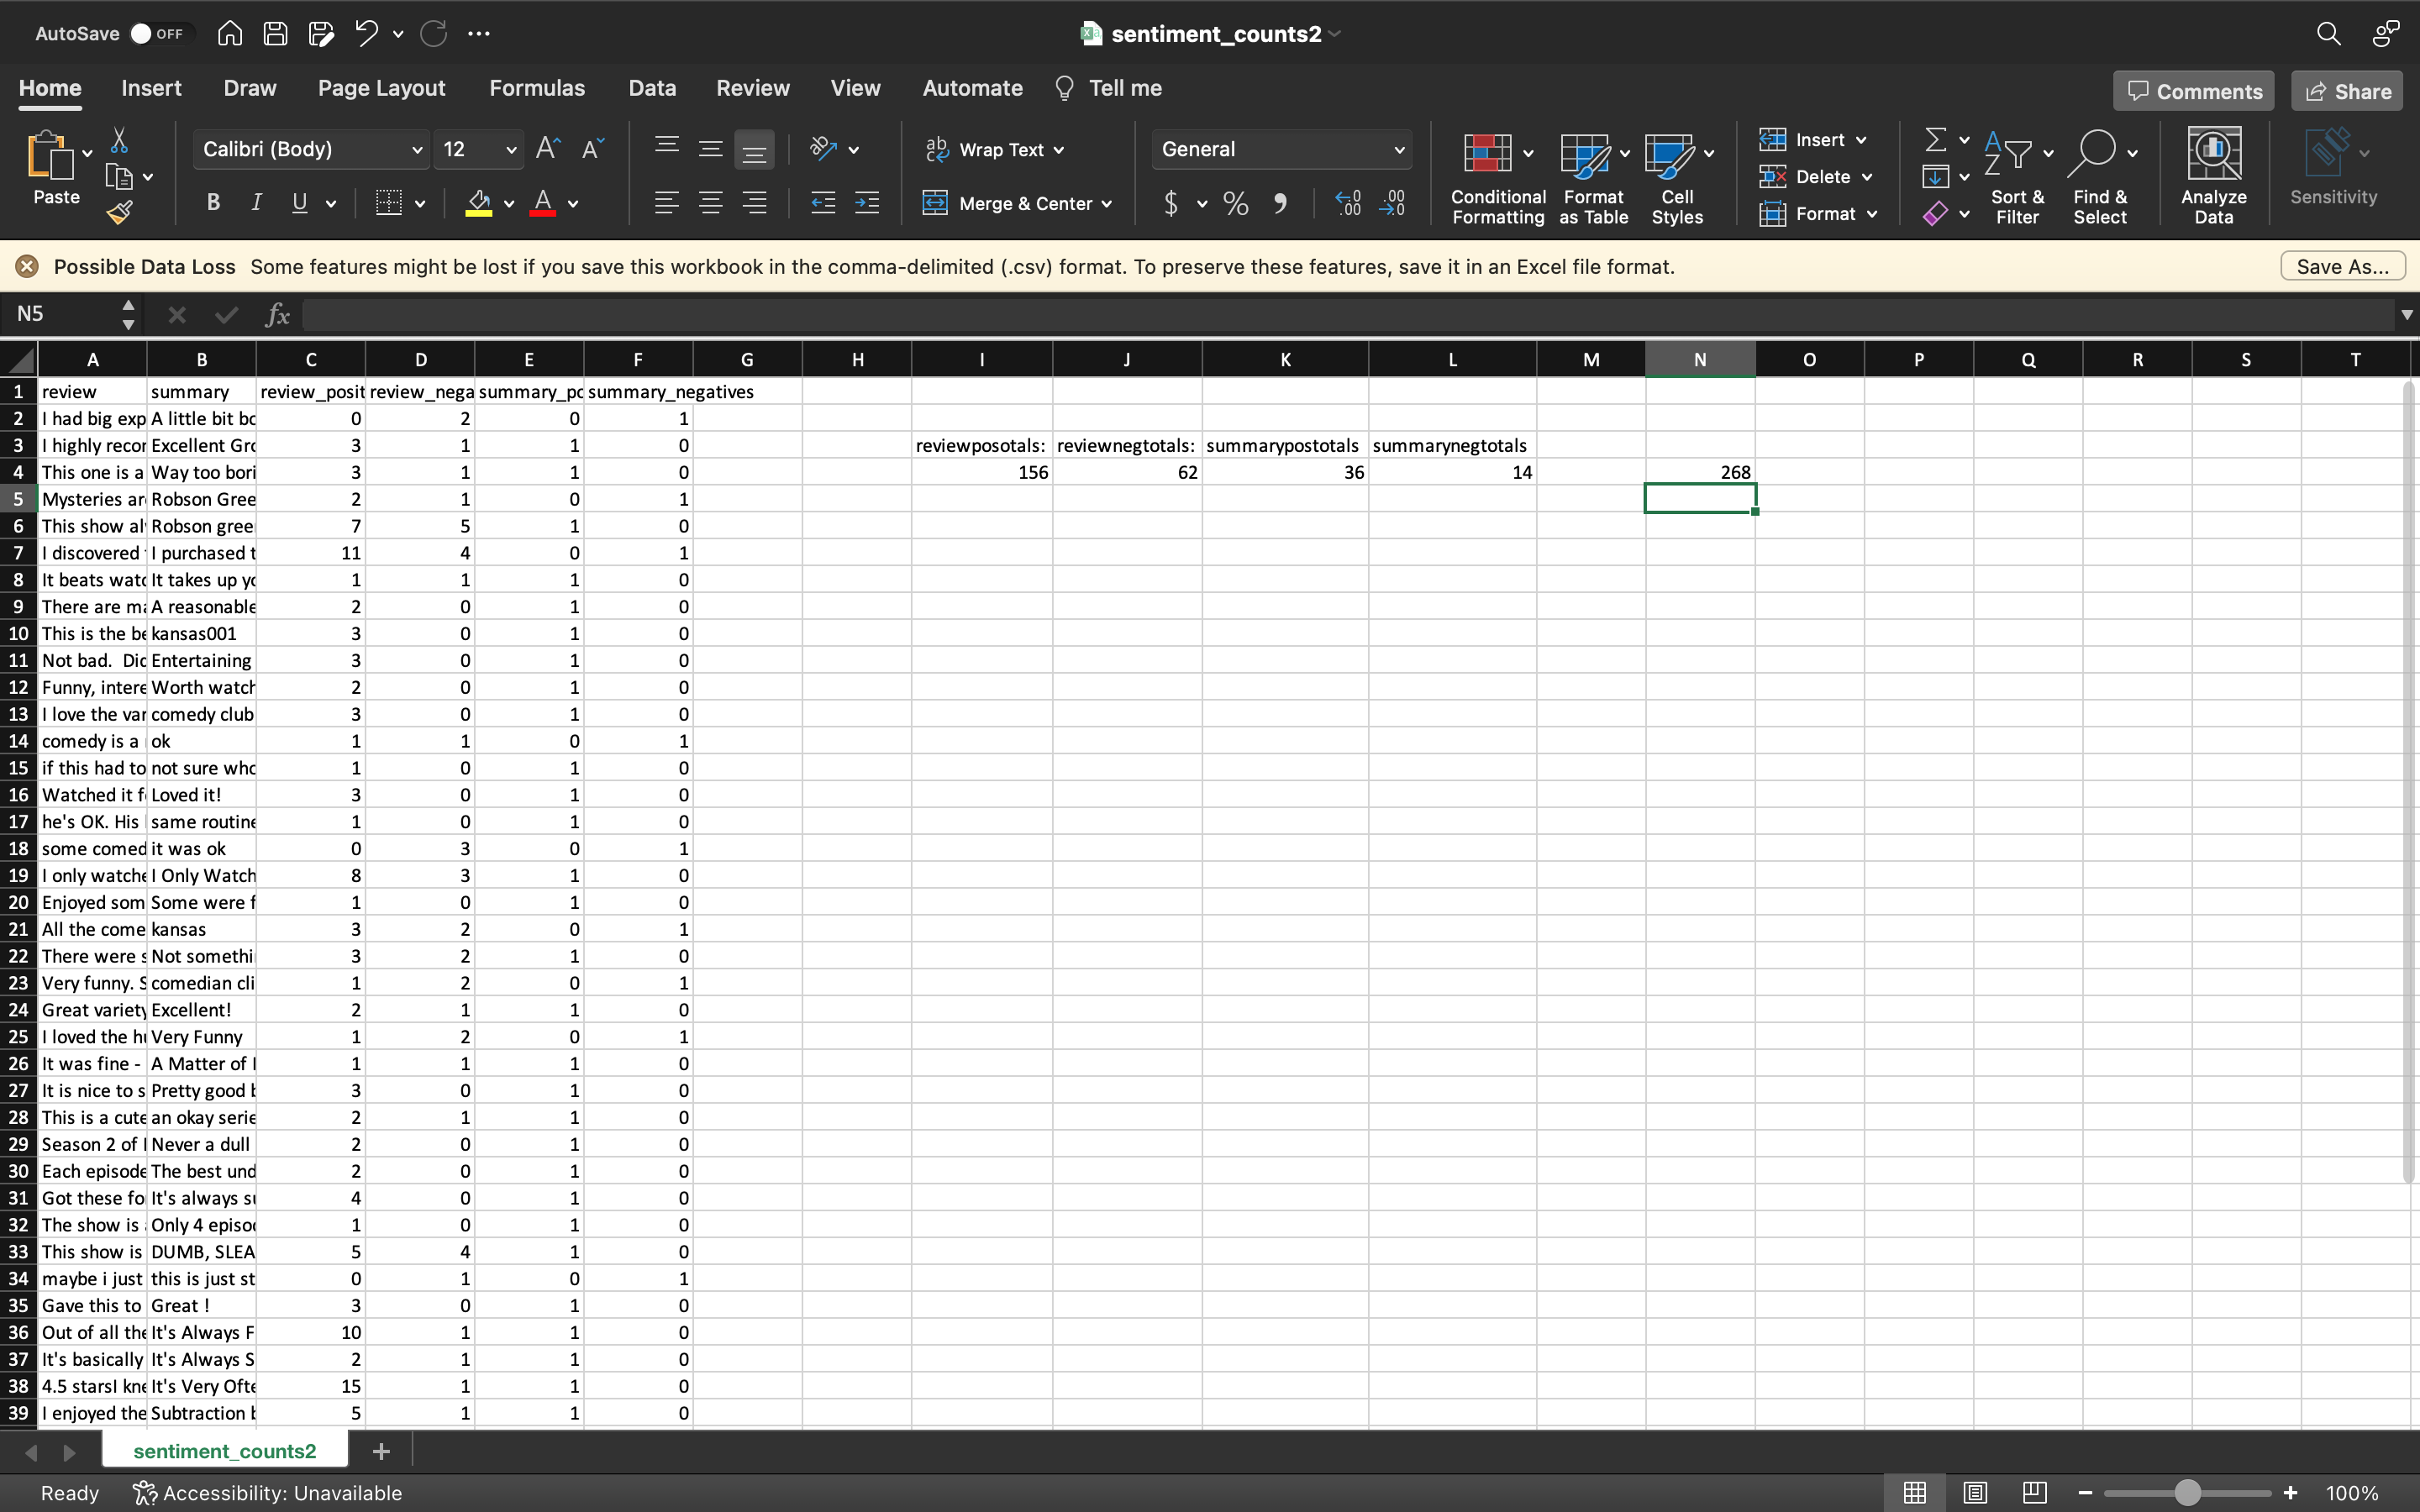

In [ ]:
results_df.to_csv('sentiment_counts2.csv',index=False)

#Comparison to Prevuous Model

Both models used the same training corpus


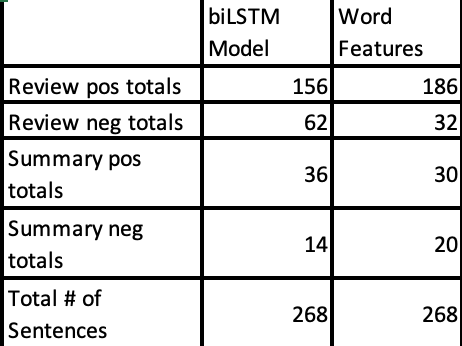